# COBAR 2023 Locomotion Code Submission

Please use this template to submit your code for your COBAR miniproject.

**PLEASE READ THE INSTRUCTIONS BELOW CAREFULLY.**

**Google Colab:** It is your responsibility to make sure that your code can be executed without error on Google Colab. You may use your own machine for development, but in the end we will use Colab to determine whether your code runs. You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."

**Where to put your code:** Please only fill your code in places indicated by the following. These cells are provided flexibly enough, and you should be able to easily add your custom import/loading/preprocessing/stepping code. You may also use common `*.py` module files and import functions/classes from these modules.
```Python
# ========== YOUR CODE BELOW ==========
... write your code here
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
```

**Terrain types:** Once you have completed this notebook for flat terrain, duplicate 2 more copies of this notebook, and change the terrain type to "gapped" and "blocks" respectively. Make sure you can run all three notebooks on Colab.

**Stabilization time:** Recall from the decentralized control demo: it might be helpful to first run a number of steps (`n_steps_stabil`) without locomotion so the fly has a chance to stabilize on the ground. This is allowed and does not count toward the 1-second simulation time.

**What to submit:** Please submit the following files via Moodle:
1. The three *executed* notebooks (ie. the outputs of the code blocks are printed). Name these files "submission_flat.ipynb", "submission_gapped.ipynb", and "submission_blocks.ipynb"
2. The three output videos: "output_flat.mp4", "output_gapped.mp4", and "output_blocks.mp4"
3. Any data file that are required for the notebooks to run (eg. parameter files, additional configurations, ...). In other words, include any file that you are loading to the notebooks. We will download these files to the same directory/folder as the notebook files before running the notebooks.
4. If you have any `*.py` module file from which you imported variables, functions, or classes, included these files too.

---

In [82]:
# #@title Install `flygym` on Colab

# # This block is modified from dm_control's tutorial notebook
# # https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    print('Installing flygym')
    !pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during dm_control installation. Check the shell '
            'output above for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    print('Checking that the flygym installation succeeded...')
    try:
        import flygym
        from flygym import envs
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during flygym installation. Check the shell '
            'output above for more information.\n')
    else:
        del envs, flygym
else:
    print('Skipping - not on Colab')

Skipping - not on Colab


You may install any additional packages here with pip. NumPy should already be installed; it's merely a demonstration of the syntax.

In [83]:
# ========== YOUR CODE BELOW ==========
!pip install numpy
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

The following are some of the modules imported in the demo notebooks:

In [84]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

You may import any additional modules here:

In [85]:
# ========== YOUR CODE BELOW ==========

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

We select the terrain type here. **YOUR CODE MUST STILL WORK IF THIS IS CHANGED TO gapped OR blocks!**

In [86]:
terrain_type = 'gapped'  # or 'gapped' or 'blocks'

We define some other physics parameters. Thess must not be changed.

In [87]:
# You are allowed to slightly change the initial position of the fly
# if it immediately gets stuck due to unfortunate initial placement
# ========== YOUR CODE BELOW ==========
fly_pos = (0, 0, 300)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

run_time = 1
out_dir = Path(f'contest_submission_{terrain_type}')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': fly_pos,
                  'friction': (friction, 0.005, 0.0001)}

You may load any preprogrammed data here and manipulate them as needed. This can include reference step kinematics (as used in the decentralized control and centralized control notebooks), or parameter files for your artificial neural network:

In [88]:
# ========== YOUR CODE BELOW ==========
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

Next, initiate your NeuroMechFly simulation environment.

In [89]:
# ========== YOUR CODE BELOW ==========
nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         terrain = terrain_type,
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         physics_config=physics_config,
                         terrain_config=terrain_config)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

You can add arbitrary code here after initializing the `nmf` object and before running the simulation loop:

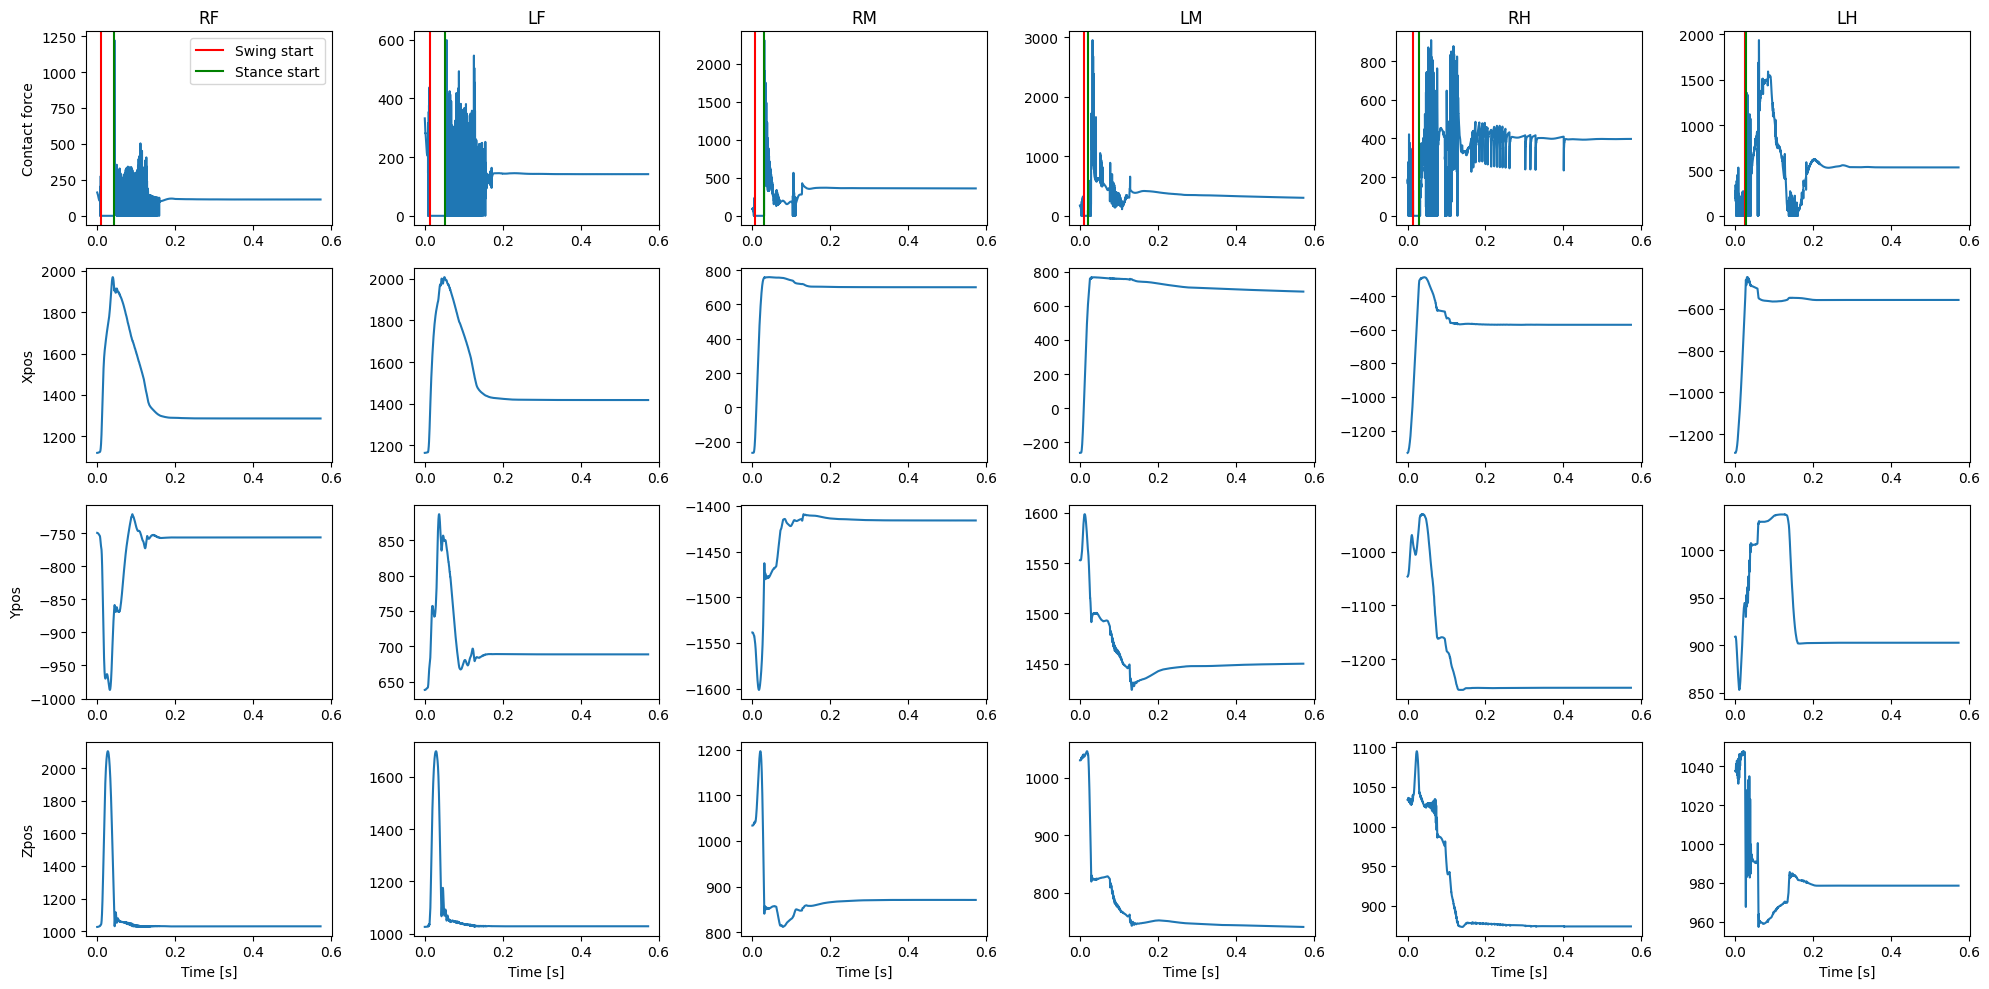

In [90]:
# ========== YOUR CODE BELOW ==========
# Interpolate 5x
num_steps_base = int(run_time / nmf.timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

# manually correct stance position   
step_data_block_manualcorrect = step_data_block_base.copy()

for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(13) # Protract the midlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-2) # Retract the hindlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)

# Stance evaluation
nmf.reset()

action = {'joints': step_data_block_manualcorrect[:, 0]}
obs, _ = nmf.step(action)
i = 0
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
all_tarsus5_pos = {l:[] for l in legs}


# Run until the fly speed is less than 50 micron/sec or 50000 steps
while np.sum(np.abs(obs["fly"][1])) > 50 and i < 50000:
    action = {'joints': step_data_block_manualcorrect[:, 0]}
    obs, _ = nmf.step(action)
    i += 1
    nmf.render()
   
# Keep track of the time it takes to stabilize
n_steps_stabil = i


# Step evaluation
nmf.reset()

# Initialize some useful helper variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# Map the id of the end effector (Tarsus5) to the leg it belongs to
leg_to_end_effector_id = {leg:i for i, end_effector in enumerate(nmf.end_effector_names) for leg in legs if leg in end_effector if leg in end_effector}

# Number of timesteps between each (fly) step
n_rest_timesteps = n_steps_stabil

# Map the id of the force sensors to the leg it belongs to
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)


# Record the touch sensor data for each leg for each timepoint
touch_sensor_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1))

# Get the position of the last segment of the tarsus for each leg in the 
leg_tarsi_pos_id = {leg:[i] for leg in legs for i, joint in enumerate(nmf.actuated_joints) if leg in joint and "Tarsus1" in joint}
position_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1, 3))

# Run the simulation until the fly is stable
for k in range(n_steps_stabil):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}
        obs, info = nmf.step(action)
        nmf.render()
# Keep track of the time it takes to stabilize
n_steps_stabil = i

# Lets step each leg on after the other collect touch sensor data as well as 3d coordinates of the last segment of the tarsus
for i, leg in enumerate(legs):
    
    # "Boolean" like indexer for the stepping leg
    joints_to_actuate = np.zeros(len(nmf.actuated_joints)).astype(int)
    joints_to_actuate[match_leg_to_joints == i] = 1
    
    for k in range(interp_step_duration):
        # Advance the stepping in the joints of the stepping leg
        joint_pos = step_data_block_manualcorrect[joint_ids, joints_to_actuate*k]
        action = {'joints': joint_pos}
        obs, info = nmf.step(action)
        # Get the touch sensor data from physics (sum of the Tarsus bellonging to a leg)
        touch_sensor_data[i, k] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        # Get the position data from physics
        position_data[i, k, :] = obs["end_effectors"].reshape(len(legs), 3)[leg_to_end_effector_id[leg]] #Get the position data from physics

        nmf.render()

    # Rest between steps
    for j in range(n_rest_timesteps):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}
        obs, info = nmf.step(action)
        touch_sensor_data[i, k+j] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        position_data[i, k+j, :] = obs["end_effectors"].reshape(len(legs), 3)[leg_to_end_effector_id[leg]] #Get the position data from physics
        nmf.render()

# Define swing start, stance start and swing duration
fig, axs = plt.subplots(4, len(legs), figsize=(20, 10))
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep

# Initialize variables
leg_swing_starts = {}
leg_stance_starts = {}
leg_swing_dur = {}

stride = 20 # Number of timesteps to check for contact
eps = 10 # Threshold for detecting contact

for i, leg in enumerate(legs):
    # Plot contact forces
    axs[0, i].plot(t, touch_sensor_data[i, :])
    k = 0
    # Until you find a swing onset keep going (as long as k is less than the length of the data)
    while k < len(touch_sensor_data[i]) and not np.all(touch_sensor_data[i, k:k+stride] == 0):
        k += 1
    swing_start = k
    if k < len(touch_sensor_data[i]):
        # Find the first time the contact force is above the threshold
        stance_start = np.where(touch_sensor_data[i, swing_start:] > eps)[0][0] + swing_start
        axs[0, i].axvline(t[swing_start], color='r', label="Swing start")
        axs[0, i].axvline(t[stance_start], color='g', label="Stance start")
        if i == 0:
            axs[0, i].legend()
        leg_swing_starts[leg] = swing_start
        leg_stance_starts[leg] = stance_start
        leg_swing_dur[leg] = stance_start - swing_start
    else:
        leg_swing_starts[leg] = 0
        leg_stance_starts[leg] = 0
        
    # Plot 3d coordinates of the last segment of the tarsus
    axs[1, i].plot(t, position_data[i, :, 0])
    axs[2, i].plot(t, position_data[i, :, 1])
    axs[3, i].plot(t, position_data[i, :, 2])
    axs[0, i].set_title(leg)
    if i == 0:
        axs[0, i].set_ylabel('Contact force')
        axs[1, i].set_ylabel('Xpos')
        axs[2, i].set_ylabel('Ypos')
        axs[3, i].set_ylabel('Zpos')
for j in range(len(legs)):
    axs[-1, j].set_xlabel('Time [s]')    

plt.tight_layout()
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

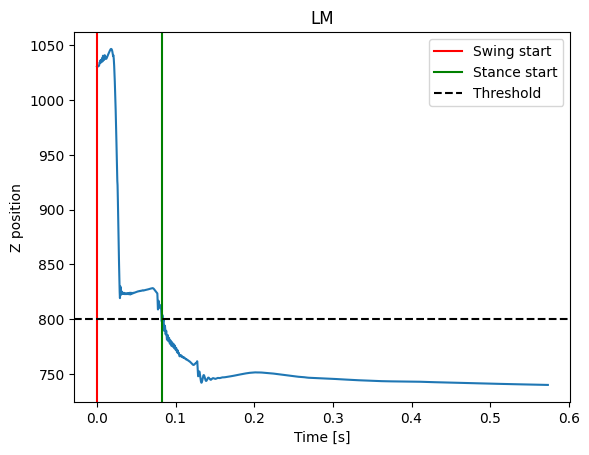

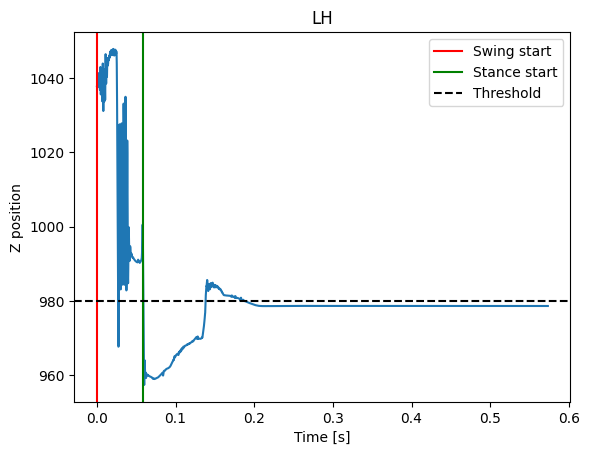

In [91]:
# ========== YOUR CODE BELOW ==========
# Manually change swing definition
threshold = 800
swing_idx = np.where(position_data[3, :, 2]>threshold)[0]
discountinuities_idx = np.where(np.diff(swing_idx) != 1)[0]
leg_swing_starts['LM'] = swing_idx[0]
leg_swing_dur['LM'] = (swing_idx[discountinuities_idx[0]]+1) - swing_idx[0]
leg_stance_starts ['LM'] = swing_idx[discountinuities_idx[0]] +1
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep
plt.plot(t, position_data[3, :, 2])
plt.axvline(t[leg_swing_starts['LM']], color='r', label="Swing start")
plt.axvline(t[leg_stance_starts['LM']], color='g', label="Stance start")
plt.axhline(threshold, color='k', ls='--', label="Threshold")
plt.ylabel('Z position')
plt.xlabel('Time [s]')
plt.title('LM')
plt.legend()
plt.show()

threshold = 980
swing_idx = np.where(position_data[5, :, 2]>threshold)[0]
discountinuities_idx = np.where(np.diff(swing_idx) != 1)[0]
leg_swing_starts['LH'] = swing_idx[0]
leg_swing_dur['LH'] = (swing_idx[discountinuities_idx[1]]+1) - swing_idx[0]
leg_stance_starts ['LH'] = swing_idx[discountinuities_idx[1]] +1
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep
plt.plot(t, position_data[5, :, 2])
plt.axvline(t[leg_swing_starts['LH']], color='r', label="Swing start")
plt.axvline(t[leg_stance_starts['LH']], color='g', label="Stance start")
plt.axhline(threshold, color='k', ls='--', label="Threshold")
plt.ylabel('Z position')
plt.xlabel('Time [s]')
plt.title('LH')
plt.legend()
plt.show()
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

In [92]:
# ========== YOUR CODE BELOW ==========
# Save the data, the step_timing and the number of stabilisation steps
with open(out_dir / "manual_corrected_data.pickle", 'wb') as handle:
    pickle.dump([step_data_block_manualcorrect, leg_swing_starts, leg_swing_dur, leg_stance_starts, n_steps_stabil], handle, protocol=pickle.HIGHEST_PROTOCOL)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

In [93]:
# ========== YOUR CODE BELOW ==========
# Initialize simulation
n_stabilisation_steps = 500
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# Correpsonding legs for the different rules
rule1_corresponding_legs = {"LH":["LM"], "LM":["LF"], "LF":[], "RH":["RM"], "RM":["RF"], "RF":[]}
rule2_corresponding_legs = {"LH":["LM", "RH"], "LM":["LF", "RM"], "LF":["RF"], "RH":["RM", "LH"], "RM":["RF", "LM"], "RF":["LF"]}
rule3_corresponding_legs = {"LH":["RH"], "LM":["LH", "RM"], "LF":["LM", "RF"], "RH":["LH"], "RM":["RH", "LM"], "RF":["LF", "RM"]}
rule5_corresponding_legs = {"LH":["RH", "LM"], "LM":["RM", "LF", "LH"], "LF":["RF", "LM"], "RH":["LH", "RM"], "RM":["RF", "RH", "LM"], "RF":["RM", "LF"]}
rule6_corresponding_legs = {"LH":["LH"], "LM":["LM"], "LF":["LF"], "RH":["RH"], "RM":["RM"], "RF":["RF"]}

# Weights for the different rules
rule1_weight = -1e4
rule2_weight = 2.5
rule2_weight_contralateral = 1
rule3_weight = 1*1e-3
rule3_weight_contralateral = 0.5*1e-3
rule5_parameter = 0.1
rule6_weight = 2

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg):
            leg_force_sensors_ids[leg].append(i)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

In [94]:
def activate_rule1(leg_contact_forces, i, window_size=20):
    # Rule 1 is active if the leg is in swing
    if i < window_size:
         window_size = i
    return np.all(leg_contact_forces[i-window_size:i] <= 0)

def activate_rule2(leg_contact_forces, i, leg_touchdown_counter, touchdown_duration=100, window_size=10):
    # The rule 2 is active if the contact force was zero for a couple of steps and then it increases
    # The duration of this effect is fixed by the touchdown_duration
    if i < window_size:
         window_size = i
    if leg_touchdown_counter == touchdown_duration:
            leg_touchdown_counter = 0
    if leg_touchdown_counter <= 0 and leg_contact_forces[i] > 0 and np.all(leg_contact_forces[i-window_size:i-1] <= 0):
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    if leg_touchdown_counter > 0:
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    else:
        return False, leg_touchdown_counter


def rule3_contribution(swing_stance, leg_contact_forces, i, leg_last_max_stance_force, time_since_last_max_stance, window_size=20):
    #Initialize rule 3 contribution
    contribution = 0
    # If the leg is in swing there is no contribution
    if (swing_stance > 0) or np.median(np.diff(leg_contact_forces[i-window_size:i])) > 0 and time_since_last_max_stance > 0:
        return contribution, 0, 0
    # If the leg is in stance the contribution is proportinal to the current leg stance duration
    else:
        contribution = np.abs(swing_stance)
        return contribution, 0, 0
    
def rule5_decrease_increase_timestep(leg_contact_forces, i, counter_since_last_increase, prev_output, min_decrease_interval=50, window_size=20):
    # This function allows to regulate the balance if the force is increased in one leg

    # Initialize the returned value
    step_size_action = 0
    if i < window_size:
        window_size = i
    # Count the number of steps since the last forc increase
    if counter_since_last_increase < min_decrease_interval and counter_since_last_increase!= 0:
        counter_since_last_increase += 1
    else:
        counter_since_last_increase = 0
        # if force decreases
        if np.median(np.diff(leg_contact_forces[i-window_size:i])) < 1 and  prev_output == 1:
            step_size_action = -1 
    # if force increases
    if np.median(np.diff(leg_contact_forces[i-window_size:i])) > 1 and  counter_since_last_increase == 0:
        step_size_action = 1
        counter_since_last_increase += 1
    return step_size_action, counter_since_last_increase

def activate_rule6(leg_contact_forces, i, window_size=300):
    # The rule 6 is active if the contact force of the leg is equal to 0 since a large number of timesteps
    # This function return the number of steps since which the force is equal to 0
    if i < window_size:
         window_size = i
    # Detect where the force is equal to 0
    counter_0 = np.where(leg_contact_forces == 0)[0]
    counter_last_0 = np.where(np.diff(counter_0) != 1)[0]
    if counter_0[-1] == i:
        if not np.any(counter_last_0):
              counter = counter_0[-1] - counter_0[0]
        else:
             counter = counter_0[-1] - counter_0[counter_last_0[-1]+1]
    else:
        counter = 0
    returned_bool = np.all(leg_contact_forces[i-window_size:i] <= 0)
    return returned_bool, counter

In [95]:
def update_stepping_advancement(stepping_advancement, i, legs, interp_step_duration, corr_leg_action, rule5_parameter, swing_stance, leg_swing_dur):
    # This function updates the joints angles at each step
    for k, leg in enumerate(legs):
        # Initial step and swing duration
        step_dur = interp_step_duration
        swing_dur = leg_swing_dur[leg]
        
        # If the rule 5 indicates to update the balance
        if corr_leg_action[k]> 0:
            # If the leg is in swing, the swing phase is decreased
            if swing_stance[k] > 0:
                swing_dur = swing_dur - rule5_parameter*swing_dur
            # If the leg is in stance, the stance phase is increased
            if swing_stance[k] <= 0:
                step_dur = interp_step_duration + rule5_parameter*interp_step_duration
                
        if swing_stance[k] == 0 and stepping_advancement[k] >= step_dur-1:
            stepping_advancement[k] = leg_stance_starts[leg]
        # If the leg is in swing phase and does not reach the swing duration limit yet, the leg continues its swing phase
        if swing_stance[k] > 0 and swing_stance[k] <= swing_dur:
            stepping_advancement[k] +=1
            swing_stance[k] += 1
        # If the leg is in swing phase and reaches the swing duration limits, the leg is reinitializes to its initial stance position
        if swing_stance[k] > swing_dur:
            swing_stance[k] = 0
            stepping_advancement[k] = 0
        # If the leg is in stance phase and does not reach the step duration limit yet, the leg continues its stance phase
        if swing_stance[k] <= 0 and np.abs(swing_stance[k])<(step_dur - leg_stance_starts[leg]):
            stepping_advancement[k] = 0
            swing_stance[k] -= 1
        # If the leg is in stance phase and reaches the step duration limits, the leg is reinitializes to its initial stance position        
        if swing_stance[k] <= 0 and np.abs(swing_stance[k])>=(step_dur - leg_stance_starts[leg]):
            stepping_advancement[k] = 0
            swing_stance[k] = 0
    # Return the updated joint angles for the different leg joints
    return stepping_advancement

def compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                       rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                       rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                       leg_corresp_id, leg_stance_starts, interp_step_duration, leg_last_max_stance_force, time_since_last_max_stance,
                       all_legs_contact_forces, i, leg_touchdown_counter, counter_since_last_increase, legs_prev_step_size_action, swing_stance, corr_leg_action, rule6_weight):

    # Initialize a variable to store the different scores
    leg_scores = np.zeros(len(legs))

    #Iterate through legs to compute score
    for k, leg in enumerate(legs):
        rule1_isactive_legs = activate_rule1(all_legs_contact_forces[:, k], i)
        if (rule1_isactive_legs==True):
            # If the rule 1 is active the corresponding leg scores are updated
            leg_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]]] += rule1_weight*(swing_stance[k]>0).astype(float)
            all_legs_rule1_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]], i] += rule1_weight*(swing_stance[k]>0).astype(float)       
        rule2_isactive_legs, leg_touchdown_counter[k] = activate_rule2(all_legs_contact_forces[:, k], i, leg_touchdown_counter[k])
        if (rule2_isactive_legs == 1):
        # If the rule 2 is active the corresponding leg scores are updated           
            for l in rule2_corresponding_legs[leg]:
                if l[0] == leg[0]:
                    #ipsilateral leg
                    leg_scores[leg_corresp_id[l]] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])- np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
                    all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])- np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
                else:
                    #contralateral leg  
                    leg_scores[leg_corresp_id[l]] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])- np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
                    all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])- np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
        rule3_contributions_legs, leg_last_max_stance_force[k], time_since_last_max_stance[k] = rule3_contribution(swing_stance[k],all_legs_contact_forces[:,k],i, leg_last_max_stance_force[k], time_since_last_max_stance[k])
        for l in rule3_corresponding_legs[leg]:
            # Corresponding leg scores are updated with the given contribution 
            if l[0] == leg[0]:
                leg_scores[leg_corresp_id[l]] += rule3_weight*rule3_contributions_legs*(np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight*rule3_contributions_legs*(np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
            else:
                leg_scores[leg_corresp_id[l]] += rule3_weight_contralateral*rule3_contributions_legs*(np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight_contralateral*rule3_contributions_legs*(np.abs(swing_stance[k])) if swing_stance[k]<=0 else 0
 
        step_size_action, counter_since_last_increase[k] = rule5_decrease_increase_timestep(all_legs_contact_forces[:,k], i, counter_since_last_increase[k], legs_prev_step_size_action[k], min_decrease_interval=50, window_size=10)
        # Rule 5 returns the need to adjust the balance
        if step_size_action == 1:
            legs_prev_step_size_action[k] = step_size_action
        elif step_size_action == 0 and legs_prev_step_size_action[k] == 1 and counter_since_last_increase[k]>0:
            legs_prev_step_size_action[k] = 1
        elif step_size_action == 0 and legs_prev_step_size_action[k] == 1 and counter_since_last_increase[k]==0:
            legs_prev_step_size_action[k] = 0
        elif step_size_action == -1:
            legs_prev_step_size_action[k] = 0
        for l in rule5_corresponding_legs[leg]:
            # No needs to adjust the balance
            if legs_prev_step_size_action[k] == 0:
                corr_leg_action[leg_corresp_id[l]] = 0
            # Needs to adjust the balance
            if legs_prev_step_size_action[k] > 0:
                corr_leg_action[leg_corresp_id[l]] = 1
        
        rule6_isactive_legs, count = activate_rule6(all_legs_contact_forces[:, k], i)
        if (rule6_isactive_legs==True):
        # If the rule 6 is active the corresponding leg scores are updated
            leg_scores[[leg_corresp_id[l] for l in rule6_corresponding_legs[leg]]] += rule6_weight*count
    return leg_scores, legs_prev_step_size_action, corr_leg_action, counter_since_last_increase

In [103]:
# Define some additional empty list to store some data for plotting metrics
y_pos_hist = []
side_stability_hist = []
forward_backward_stability_hist = []
pitch_hist = []
roll_hist = []
raw_obs_hist = []

# Define some function needed for plotting metrics
def get_delta_forces_side_stability(raw_obs):
    legs_side_ordered = ["RF", "RM", "RH", "LF", "LM", "LH"]
    leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_side_ordered])
    delta_forces = np.sum(leg_contact_forces[:3])/3 - np.sum(leg_contact_forces[3:])/3 
    return delta_forces

def get_delta_forces_forward_backward_stability(raw_obs):
    legs_forward_ordered = ["RF", "LF", "RH", "LH"]
    leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_forward_ordered])
    delta_forces = np.sum(leg_contact_forces[:2])/2 - np.sum(leg_contact_forces[2:])/2
    return delta_forces

Now, run the simulation:

In [104]:
# Final preparation here
# ========== YOUR CODE BELOW ==========
# Number of steps initialization
num_steps = n_stabilisation_steps + num_steps_base
# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)
swing_stance = np.zeros(len(legs)).astype(int)
# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))
obs_list_cruse_flat = []
leg_touchdown_counter = np.zeros(len(legs))
leg_last_max_stance_force = np.zeros(len(legs))
time_since_last_max_stance = np.zeros(len(legs))
coor_leg_action = np.zeros(len(legs))
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
counter_since_last_increase = np.zeros(len(legs))
legs_prev_step_size_action = np.zeros(len(legs))

# If many legs have a closed score
percent_margin = 0.001
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

nmf.reset()
np.random.seed(42)
x_pos_hist = []

# Main simulation loop
for i in trange(num_steps):
    # You may insert any code before stepping the physics simulation...
    # ========== YOUR CODE BELOW ==========
    # Decide in which leg to raise according to the leg scores
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1):
        initiating_leg = None

    # If the leg designed to be raised is in stance its joints are set to the swing start angles
    elif swing_stance[initiating_leg] <= 0 and i > n_stabilisation_steps:
        swing_stance[initiating_leg] = 1
        stepping_advancement[initiating_leg] == leg_swing_starts[legs[initiating_leg]]
        print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
  
    # If the fly is no more in the stabilization phase, the advancement is updated
    if i > n_stabilisation_steps:
        stepping_advancement = update_stepping_advancement(stepping_advancement, i, legs, interp_step_duration, coor_leg_action, rule5_parameter, swing_stance, leg_swing_dur)

    # If the fly is in the stabilization phase the joints are set to the initial stance phase
    if i <= n_stabilisation_steps:
        joint_pos = step_data_block_manualcorrect[joint_ids, 0]
        action = {'joints': joint_pos}
        obs, info = nmf.step(action)
        nmf.render()
        obs_list_cruse_flat.append(obs)
        if i == 0:
            all_legs_contact_forces = np.array([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])
            all_legs_contact_forces = all_legs_contact_forces.reshape(1, 6)
        else:
            all_legs_contact_forces = np.vstack((all_legs_contact_forces,
                                            np.array([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])))

    if i > n_stabilisation_steps:
        joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
        action = {'joints': joint_pos}
        obs, info = nmf.step(action)
        nmf.render()
        obs_list_cruse_flat.append(obs)
        all_legs_contact_forces = np.vstack((all_legs_contact_forces, np.array([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])))
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    
    # ... and after stepping the physics simulation
    # ========== YOUR CODE BELOW ==========
    # Compute the new leg scores
    leg_scores, legs_prev_step_size_action, coor_leg_action, counter_since_last_increase = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    leg_corresp_id, leg_stance_starts, interp_step_duration, leg_last_max_stance_force, time_since_last_max_stance,
                                    all_legs_contact_forces, i, leg_touchdown_counter, counter_since_last_increase, legs_prev_step_size_action, swing_stance, coor_leg_action, rule6_weight)
    # Store the different values needed for plotting the metrics
    all_leg_scores[:, i] = leg_scores
    side_stability = get_delta_forces_side_stability(obs)
    forward_backward_stability = get_delta_forces_forward_backward_stability(obs)
    x_pos_hist.append(obs['fly'][0, 0])
    y_pos_hist.append(obs['fly'][0, 1])
    side_stability_hist.append(side_stability)
    forward_backward_stability_hist.append(forward_backward_stability)
    pitch_hist.append(obs['fly'][2, 1])
    roll_hist.append(obs['fly'][2, 0])
    raw_obs_hist.append(obs)
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    # Report the final x position of the base of the fly here. If you wrote
    # a wrapper around `NeuroMechFlyMuJoCo` (for your own RL pipeline, for
    # example), you may modify the code below to faithfully report the final
    # x position of the base of the fly depending on your implementation.
    # Obviously, don't hard code a very large number :)

# Save video here. SUBMIT THIS VIDEO ALONG WITH THE CODE!
nmf.save_video(out_dir / f"output_{terrain_type}.mp4")

nmf.close()


  5%|▍         | 494/10500 [00:08<02:09, 77.18it/s]

Stepping leg:  LH  at step:  501
Stepping leg:  RM  at step:  503


  7%|▋         | 715/10500 [00:11<02:13, 73.09it/s]

Stepping leg:  RM  at step:  722


  9%|▉         | 970/10500 [00:14<02:13, 71.61it/s]

Stepping leg:  RM  at step:  966


 10%|█         | 1055/10500 [00:15<02:07, 73.79it/s]

Stepping leg:  LM  at step:  1052


 12%|█▏        | 1208/10500 [00:17<01:58, 78.66it/s]

Stepping leg:  RM  at step:  1201


 13%|█▎        | 1344/10500 [00:19<01:53, 80.35it/s]

Stepping leg:  LH  at step:  1340


 14%|█▎        | 1429/10500 [00:20<01:56, 77.95it/s]

Stepping leg:  RF  at step:  1426


 18%|█▊        | 1888/10500 [00:26<01:55, 74.53it/s]

Stepping leg:  LF  at step:  1874


 18%|█▊        | 1939/10500 [00:27<01:50, 77.14it/s]

Stepping leg:  LM  at step:  1931


 21%|██        | 2211/10500 [00:31<01:54, 72.32it/s]

Stepping leg:  LH  at step:  2210
Stepping leg:  RH  at step:  2215


 22%|██▏       | 2262/10500 [00:31<01:48, 76.20it/s]

Stepping leg:  LF  at step:  2254


 23%|██▎       | 2381/10500 [00:33<01:49, 74.46it/s]

Stepping leg:  RM  at step:  2371


 25%|██▍       | 2592/10500 [00:40<06:30, 20.24it/s]

Stepping leg:  RM  at step:  2590


 25%|██▌       | 2646/10500 [00:42<03:50, 34.12it/s]

Stepping leg:  LF  at step:  2643


 26%|██▌       | 2750/10500 [00:45<02:46, 46.42it/s]

Stepping leg:  LH  at step:  2741


 28%|██▊       | 2890/10500 [00:48<02:37, 48.38it/s]

Stepping leg:  RF  at step:  2877


 29%|██▉       | 3022/10500 [00:53<03:05, 40.29it/s]

Stepping leg:  LF  at step:  3022


 31%|███       | 3278/10500 [01:02<04:12, 28.65it/s]

Stepping leg:  LH  at step:  3272


 32%|███▏      | 3377/10500 [01:06<03:27, 34.35it/s]

Stepping leg:  RH  at step:  3368


 32%|███▏      | 3391/10500 [01:06<04:13, 27.99it/s]

Stepping leg:  LF  at step:  3386


 34%|███▎      | 3536/10500 [01:10<02:15, 51.25it/s]

Stepping leg:  RH  at step:  3524
Stepping leg:  RF  at step:  3535


 35%|███▍      | 3662/10500 [01:13<02:39, 42.84it/s]

Stepping leg:  RM  at step:  3664


 36%|███▌      | 3790/10500 [01:19<05:28, 20.43it/s]

Stepping leg:  LF  at step:  3787


 37%|███▋      | 3860/10500 [01:22<02:19, 47.58it/s]

Stepping leg:  LM  at step:  3863


 37%|███▋      | 3928/10500 [01:23<01:36, 67.89it/s]

Stepping leg:  LH  at step:  3927


 40%|███▉      | 4166/10500 [01:26<01:27, 72.77it/s]

Stepping leg:  RM  at step:  4159


 42%|████▏     | 4400/10500 [01:29<01:18, 77.25it/s]

Stepping leg:  RM  at step:  4403


 44%|████▍     | 4625/10500 [01:33<01:19, 73.59it/s]

Stepping leg:  RM  at step:  4622


 46%|████▋     | 4863/10500 [01:36<01:28, 63.77it/s]

Stepping leg:  RF  at step:  4866


 47%|████▋     | 4914/10500 [01:37<01:20, 69.18it/s]

Stepping leg:  RM  at step:  4918


 49%|████▉     | 5169/10500 [01:41<01:15, 70.43it/s]

Stepping leg:  RM  at step:  5162


 51%|█████▏    | 5407/10500 [01:44<01:12, 69.81it/s]

Stepping leg:  RM  at step:  5406


 54%|█████▍    | 5654/10500 [01:48<01:13, 65.74it/s]

Stepping leg:  RM  at step:  5650


 56%|█████▌    | 5867/10500 [01:51<01:12, 64.28it/s]

Stepping leg:  RM  at step:  5869


 58%|█████▊    | 6104/10500 [01:54<01:10, 62.02it/s]

Stepping leg:  RF  at step:  6113


 61%|██████▏   | 6436/10500 [01:59<01:00, 66.90it/s]

Stepping leg:  RM  at step:  6436


 64%|██████▎   | 6682/10500 [02:03<01:06, 57.70it/s]

Stepping leg:  RM  at step:  6680


 66%|██████▌   | 6919/10500 [02:06<00:42, 83.52it/s]

Stepping leg:  RM  at step:  6908


 68%|██████▊   | 7155/10500 [02:14<02:13, 25.11it/s]

Stepping leg:  RM  at step:  7152


 71%|███████   | 7405/10500 [02:21<01:25, 36.40it/s]

Stepping leg:  RM  at step:  7396


 73%|███████▎  | 7628/10500 [02:29<01:35, 29.93it/s]

Stepping leg:  RM  at step:  7624


 75%|███████▍  | 7871/10500 [02:38<00:59, 44.30it/s]

Stepping leg:  RM  at step:  7868


 77%|███████▋  | 8119/10500 [02:45<01:11, 33.34it/s]

Stepping leg:  RM  at step:  8112


 80%|███████▉  | 8358/10500 [02:53<01:08, 31.08it/s]

Stepping leg:  RM  at step:  8356


 82%|████████▏ | 8601/10500 [03:03<01:01, 31.01it/s]

Stepping leg:  RM  at step:  8600


 84%|████████▍ | 8849/10500 [03:12<01:04, 25.56it/s]

Stepping leg:  RM  at step:  8844


 87%|████████▋ | 9086/10500 [03:21<00:53, 26.41it/s]

Stepping leg:  RM  at step:  9088


 89%|████████▉ | 9334/10500 [03:31<00:22, 51.85it/s]

Stepping leg:  RM  at step:  9332


 91%|█████████▏| 9588/10500 [03:35<00:12, 70.40it/s]

Stepping leg:  RM  at step:  9576


 93%|█████████▎| 9816/10500 [03:39<00:10, 62.37it/s]

Stepping leg:  RM  at step:  9820


 96%|█████████▌| 10065/10500 [03:43<00:07, 54.63it/s]

Stepping leg:  RF  at step:  10064


 97%|█████████▋| 10218/10500 [03:45<00:04, 61.42it/s]

Stepping leg:  RM  at step:  10221


 99%|█████████▉| 10439/10500 [03:49<00:00, 65.23it/s]

Stepping leg:  RM  at step:  10440


100%|██████████| 10500/10500 [03:50<00:00, 45.65it/s]


The video should have been saved to `out_dir / f"output_{terrain_type}.mp4"`. Check that it makes sense.

Finally, let's visualize how the fly's x position changes over time:

Final position: 1.1032 mm


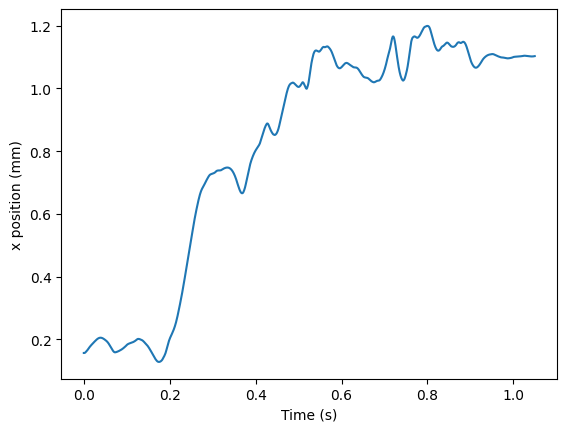

In [101]:
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(x_pos_hist) / 1000)
plt.xlabel('Time (s)')
plt.ylabel('x position (mm)')
print(f'Final position: {x_pos_hist[-1] / 1000:.4f} mm')

Final position: 0.6599 mm


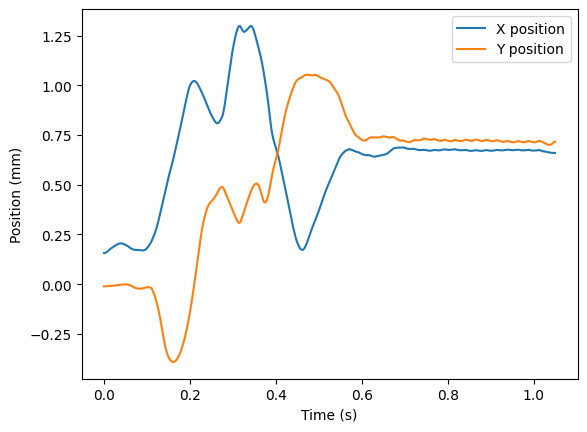

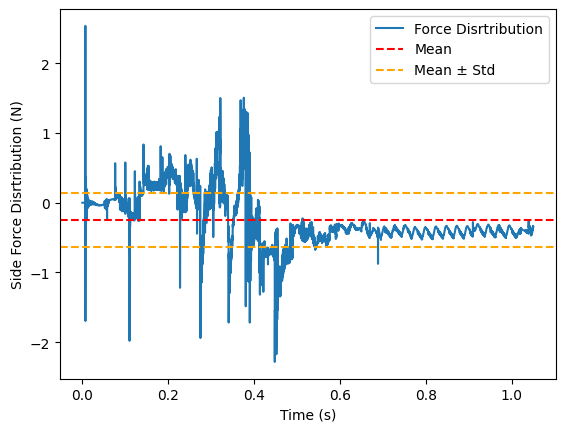

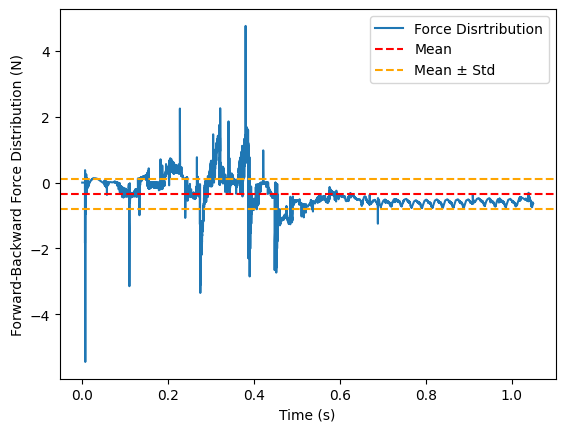

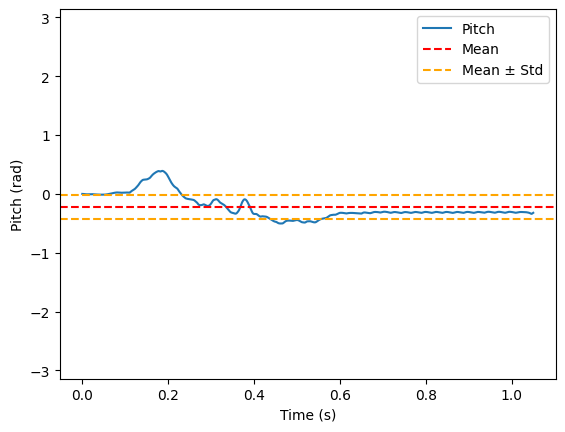

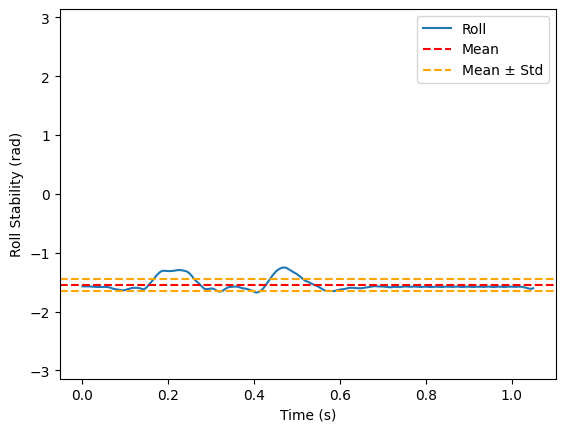

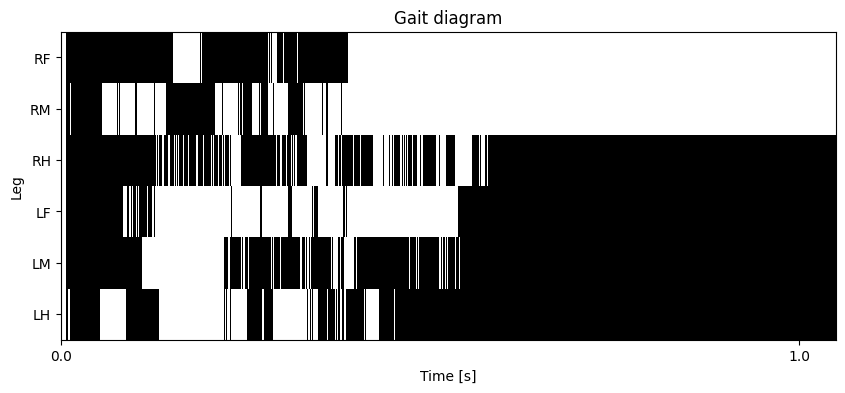

In [106]:
# Plot x postion over time
time = np.arange(len(x_pos_hist))*nmf.timestep
plt.plot(time, np.array(x_pos_hist) / 1000, label="X position")
#plt.ylabel('x position (mm)')
print(f'Final position: {x_pos_hist[-1] / 1000:.4f} mm')
#plt.show()

# Plot y position over time
#time = np.arange(len(y_pos_hist))*nmf.timestep
plt.plot(time, np.array(y_pos_hist) / 1000, label = "Y position")
#plt.ylabel('y position (mm)')
#plt.ylim(-1, 14)
#print(f'Final position: {y_pos_hist[-1] / 1000:.4f} mm')
plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')
plt.legend()
plt.show()

# Plot side force distribution over time
time = np.arange(len(side_stability_hist))*nmf.timestep
plt.plot(time, np.array(side_stability_hist)/1000)
plt.xlabel('Time (s)')
plt.ylabel('Side Force Disrtribution (N)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(side_stability_hist)/1000)
std = np.std(np.array(side_stability_hist)/1000)
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Force Disrtribution', 'Mean', 'Mean ± Std'])
# plt.ylim(-1, 14)
plt.show()

# Plot Forward-Backward force distribution
time = np.arange(len(forward_backward_stability_hist))*nmf.timestep
plt.plot(time, np.array(forward_backward_stability_hist)/1000)
plt.xlabel('Time (s)')
plt.ylabel('Forward-Backward Force Distribution (N)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(forward_backward_stability_hist)/1000)
std = np.std(np.array(forward_backward_stability_hist)/1000)
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Force Disrtribution', 'Mean', 'Mean ± Std'])
# plt.ylim(-1, 14)
plt.show()

# Plot pitch metrics over time
time = np.arange(len(pitch_hist))*nmf.timestep
plt.plot(time, np.array(pitch_hist))
plt.xlabel('Time (s)')
plt.ylabel('Pitch (rad)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(pitch_hist))
std = np.std(np.array(pitch_hist))
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Pitch', 'Mean', 'Mean ± Std'])
plt.ylim(-3.14, 3.14)
plt.show()

# Plot roll metrics
time = np.arange(len(roll_hist))*nmf.timestep
plt.plot(time, np.array(roll_hist))
plt.xlabel('Time (s)')
plt.ylabel('Roll Stability (rad)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(roll_hist))
std = np.std(np.array(roll_hist))
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Roll', 'Mean', 'Mean ± Std'])
plt.ylim(-3.14, 3.14)
plt.show()

# Plot the gait diagram
all_legs_contact = np.zeros((len(legs), num_steps))
gait_diagram_leg_order = ["RF", "RM", "RH", "LF", "LM", "LH"]
assert set(gait_diagram_leg_order) == set(legs)
for t in range(num_steps):
    for l, leg in enumerate(gait_diagram_leg_order):
        all_legs_contact[l, t] = np.sum(obs_list_cruse_flat[t]["contact_forces"][leg_force_sensors_ids[leg]]) > 0
from scipy.signal import medfilt
t_ids = np.arange(0, num_steps, 1)
time = t_ids * nmf.timestep
plt.figure(figsize=(10, 4))
plt.imshow((np.logical_not(all_legs_contact)), cmap="gray", aspect="auto", interpolation="none")
plt.xlabel("Time [s]")
plt.ylabel("Leg")
plt.yticks(np.arange(len(legs)), gait_diagram_leg_order)
plt.xticks(t_ids[::10000], time[::10000])
plt.title("Gait diagram")
plt.show()